In [ ]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import re
import random
from pathlib import Path
import cv2
import glob
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as process_mobileNetV3Large
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as process_efficientNetV2B0
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

train_path = '/content/drive/MyDrive/PaddyDisease/balanced_oversampling'
test_path  = '/content/drive/MyDrive/PaddyDisease/test_data'
IMG_SHAPE = (224, 224, 3)
batch_size = 32
classData = 10

In [ ]:
#data awal setelah dipisah secara manual. Data yang lebih dari 1000, telah dipisah secara manual
print('Dataset Training OverSampling Balanced')
for filepath in glob.glob(train_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")


print('Dataset Testing OverSampling Balanced')
for filepath in glob.glob(test_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

Dataset Training OverSampling Balanced
1000 	 tungro
1000 	 bacterial_panicle_blight
1000 	 bacterial_leaf_streak
1000 	 downy_mildew
1000 	 brown_spot
1000 	 bacterial_leaf_blight
1000 	 hispa
1000 	 dead_heart
1000 	 blast
1000 	 normal
Dataset Testing OverSampling Balanced
100 	 brown_spot
100 	 normal
100 	 downy_mildew
100 	 tungro
100 	 bacterial_leaf_streak
100 	 dead_heart
100 	 hispa
100 	 blast
100 	 bacterial_panicle_blight
100 	 bacterial_leaf_blight


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.1,
    subset="training",
    seed=123,
    label_mode='categorical',
    image_size=(224,224),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.1,
    subset="validation",
    seed=123,
    label_mode="categorical",
    image_size=(224,224),
    batch_size=batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    shuffle=False,
    label_mode="categorical",
    image_size=(224,224),
    batch_size=1
)

Found 10000 files belonging to 10 classes.
Using 9000 files for training.
Found 10000 files belonging to 10 classes.
Using 1000 files for validation.
Found 1000 files belonging to 10 classes.


In [ ]:
#Ensemble Model using Average Method

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
model_1 = load_model('/content/drive/MyDrive/PaddyDisease/PaddyDisease_EfficientNetV2B0_OverSampling_224_v2.h5')
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='EfficientNetV2B0')
model_2 = load_model('/content/drive/MyDrive/PaddyDisease/PaddyDisease_MobileNetV3Large_OverSampling_224_v2.h5')
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='MobileNetV3Large')
models = [model_1, model_2]
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
average_ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [ ]:
average_ensemble_model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=["accuracy"])

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=3)
history = average_ensemble_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
282/282 [==============================] - 2016s 7s/step - loss: 0.0881 - accuracy: 0.9824 - val_loss: 0.6618 - val_accuracy: 0.8580
Epoch 2/10
282/282 [==============================] - 41s 141ms/step - loss: 0.0942 - accuracy: 0.9832 - val_loss: 0.3549 - val_accuracy: 0.9180
Epoch 3/10
282/282 [==============================] - 43s 146ms/step - loss: 0.0488 - accuracy: 0.9922 - val_loss: 0.3435 - val_accuracy: 0.9250
Epoch 4/10
282/282 [==============================] - 41s 143ms/step - loss: 0.0388 - accuracy: 0.9957 - val_loss: 0.2968 - val_accuracy: 0.9330
Epoch 5/10
282/282 [==============================] - 41s 141ms/step - loss: 0.0239 - accuracy: 0.9970 - val_loss: 0.2983 - val_accuracy: 0.9260
Epoch 6/10
282/282 [==============================] - 41s 141ms/step - loss: 0.0225 - accuracy: 0.9966 - val_loss: 0.2789 - val_accuracy: 0.9350
Epoch 7/10
282/282 [==============================] - 41s 143ms/step - loss: 0.0288 - accuracy: 0.9942 - val_loss: 0.4476 - val_acc

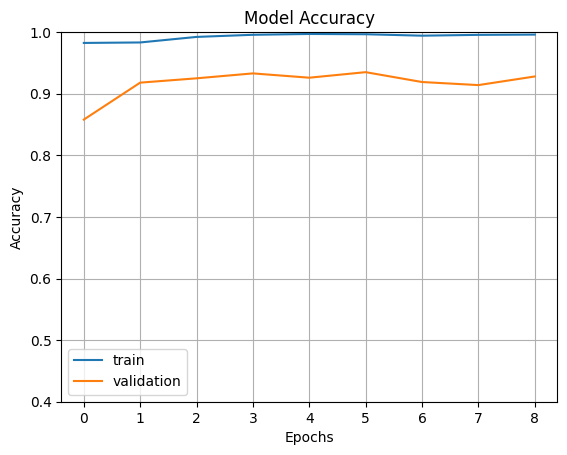

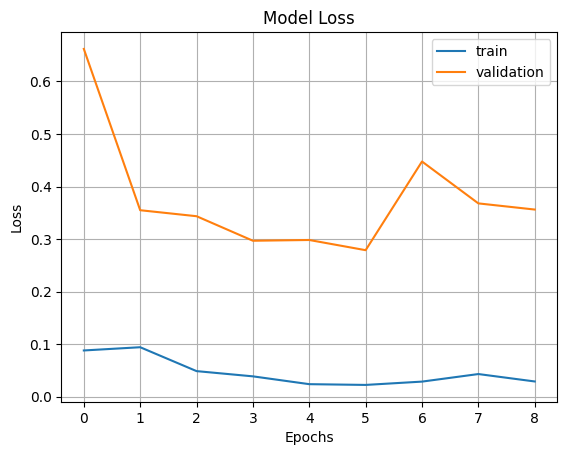

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

#predict
predictions = average_ensemble_model.predict(test_ds)

class_names = ["bacterial_leaf_blight","bacterial_leaf_streak","bacterial_panicle_blight","blast","brown_spot","dead_heart","downy_mildew","hispa","normal","tungro"]

predicted_categories = np.argmax(predictions, axis=1)

true_categories = tf.concat([y for x, y in test_ds], axis=0).numpy()
true_categories_argmax = np.argmax(true_categories, axis=1)

print(classification_report(true_categories_argmax, predicted_categories, target_names=class_names, digits=4))

1000/1000 [==============================] - 216s 212ms/step
                          precision    recall  f1-score   support

   bacterial_leaf_blight     0.9767    0.8400    0.9032       100
   bacterial_leaf_streak     0.9896    0.9500    0.9694       100
bacterial_panicle_blight     0.9789    0.9300    0.9538       100
                   blast     0.8624    0.9400    0.8995       100
              brown_spot     0.9065    0.9700    0.9372       100
              dead_heart     0.9000    0.9900    0.9429       100
            downy_mildew     0.9444    0.8500    0.8947       100
                   hispa     0.9417    0.9700    0.9557       100
                  normal     0.9029    0.9300    0.9163       100
                  tungro     0.9406    0.9500    0.9453       100

                accuracy                         0.9320      1000
               macro avg     0.9344    0.9320    0.9318      1000
            weighted avg     0.9344    0.9320    0.9318      1000



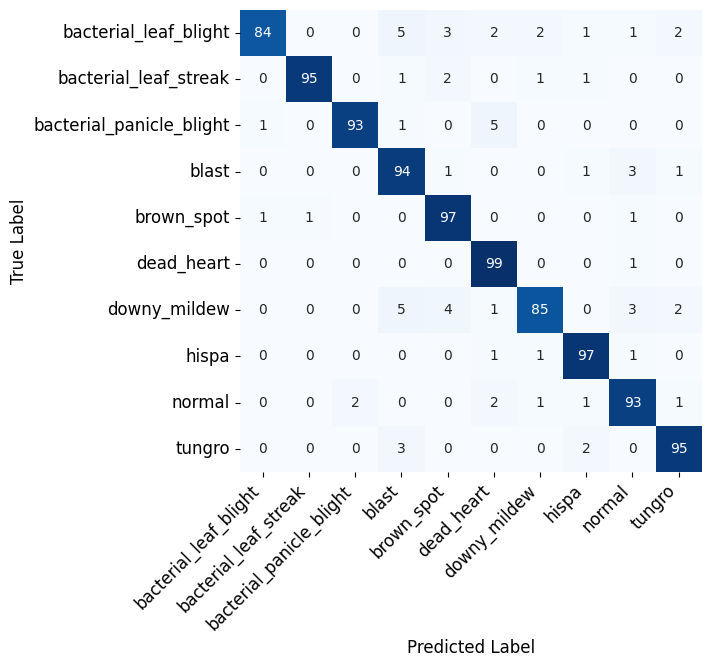

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_heatmap(true_categories_argmax, predicted_categories, class_names, ax, title="EfficientNetV2B0-UnderSampling")    

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()

In [ ]:
average_ensemble_model.save('/content/drive/MyDrive/PaddyDisease/PaddyDisease_EnsembleAverage_OverSampling_224.h5')

ValueError: ignored